# Assignment 2 – Food.com Matrix Factorization Recommender (PyTorch)

This notebook is the code companion to the **Assignment 2 Presentation**. It follows the same five-part structure:

1. **Predictive task and evaluation plan** – explicit rating prediction and top-K recommendation on the Food.com dataset using a matrix factorization model trained with MSE and fine-tuned with BPR.
2. **Exploratory analysis, data collection, and preprocessing** – loading Food.com user–recipe–rating interactions, cleaning and filtering them, mapping IDs to integer indices, and analyzing rating/user/item distributions (including long-tail effects).
3. **Modeling** – implementing a bias-aware latent-factor matrix factorization model in PyTorch, defining the MSE loss and BPR ranking loss, and setting up the optimization and training loop.
4. **Evaluation** – computing RMSE, Hit@10, and NDCG@10; plotting learning curves; and showing qualitative recommendation examples that match the slides.
5. **Discussion and contributions** – relating the results to the PML book and the Food.com paper (Majumder et al., 2019), and summarizing the contributions required for Assignment 2.



In [1]:
# Assignment 2 – Food.com Matrix Factorization Recommender (PyTorch)
# Presentation: overview for Sections 1–5 (task, data, model, evaluation, contributions).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/en

Using device: cpu


## 1. Load and preprocess the Food.com dataset


In [ ]:
# 1. Load and preprocess the Food.com dataset
# Implements the data collection, cleaning, and basic preprocessing described in "Exploratory analysis, data collection, and preprocessing".

path = kagglehub.dataset_download("shuyangli94/food-com-recipes-and-user-interactions")
print("Path to dataset files:", path)

interactions_path = f"{path}/RAW_interactions.csv"
recipes_path = f"{path}/RAW_recipes.csv"

interactions = pd.read_csv(interactions_path)
recipes = pd.read_csv(recipes_path)

print(interactions.head())
print(recipes.head())

Path to dataset files: /Users/duynguyen/.cache/kagglehub/datasets/shuyangli94/food-com-recipes-and-user-interactions/versions/2
   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  
3  I made the Mexican topping and took it to bunk...  
4  Made the cheddar bacon topping, adding a sprin...  
                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3      

In [ ]:
# 1. Load and preprocess the Food.com dataset
# Implements the data collection, cleaning, and basic preprocessing described in "Exploratory analysis, data collection, and preprocessing".

recipes_small = recipes[["id", "minutes", "n_steps", "n_ingredients"]].copy()
recipes_small = recipes_small.rename(columns={"id": "recipe_id"})

df = interactions.merge(recipes_small, on="recipe_id", how="inner")

df = df[df["rating"] > 0].copy()

df["log_minutes"] = np.log1p(df["minutes"].clip(lower=0))
df["steps_per_minute"] = df["n_steps"] / (df["minutes"].replace(0, 1e-3))
df["ingredients_per_step"] = df["n_ingredients"] / (df["n_steps"].replace(0, 1e-3))

df = df.dropna(subset=["user_id", "recipe_id", "rating"]).reset_index(drop=True)

print("Number of ratings:", len(df))
print(df[["user_id", "recipe_id", "rating"]].head())

Number of ratings: 1071520
   user_id  recipe_id  rating
0    38094      40893       4
1  1293707      40893       5
2     8937      44394       4
3   126440      85009       5
4    57222      85009       5


## 2. Train/validation/test split

We do a random split into train/validation/test using NumPy only.


In [4]:
# 2. Train/validation/test split (no sklearn)  (presentation Section 2.4)
# Implements the interaction-level train/val/test split used for rating prediction and ranking evaluation.

def manual_train_val_test_split(X, y, test_size=0.2, val_size=0.25, random_state=42):
    rng = np.random.RandomState(random_state)
    n = len(X)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_test = int(n * test_size)
    test_idx = idx[:n_test]
    temp_idx = idx[n_test:]
    n_val = int(len(temp_idx) * val_size)
    val_idx = temp_idx[:n_val]
    train_idx = temp_idx[n_val:]
    def split(df_like, indices):
        if isinstance(df_like, pd.Series) or isinstance(df_like, pd.DataFrame):
            return df_like.iloc[indices].reset_index(drop=True)
        arr = np.asarray(df_like)
        return arr[indices]
    X_train = split(X, train_idx)
    y_train = split(y, train_idx)
    X_val = split(X, val_idx)
    y_val = split(y, val_idx)
    X_test = split(X, test_idx)
    y_test = split(y, test_idx)
    return X_train, X_val, X_test, y_train, y_val, y_test

feature_cols = [
    "user_id",
    "recipe_id",
    "minutes",
    "n_steps",
    "n_ingredients",
    "log_minutes",
    "steps_per_minute",
    "ingredients_per_step",
]

X = df[feature_cols].copy()
y = df["rating"].copy()

X_train, X_val, X_test, y_train, y_val, y_test = manual_train_val_test_split(X, y)

print(len(X_train), len(X_val), len(X_test))

642912 214304 214304


## 3. Simple baselines (global mean, user mean, recipe mean)


In [ ]:
# 3. Simple baselines (global mean, user mean, recipe mean)
# Computes the trivial baselines that are compared against MF in the evaluation plan.

def rmse_np(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

train_stats = X_train.copy()
train_stats["rating"] = y_train.values

global_mean = train_stats["rating"].mean()
user_mean = train_stats.groupby("user_id")["rating"].mean()
recipe_mean = train_stats.groupby("recipe_id")["rating"].mean()

def user_mean_predict(df_in):
    m = df_in["user_id"].map(user_mean)
    return m.fillna(global_mean).values

def recipe_mean_predict(df_in):
    m = df_in["recipe_id"].map(recipe_mean)
    return m.fillna(global_mean).values

y_val_user = user_mean_predict(X_val)
y_test_user = user_mean_predict(X_test)
y_val_recipe = recipe_mean_predict(X_val)
y_test_recipe = recipe_mean_predict(X_test)

print("Global mean (train):", global_mean)
print("User mean baseline RMSE (val, test):", rmse_np(y_val, y_val_user), rmse_np(y_test, y_test_user))
print("Recipe mean baseline RMSE (val, test):", rmse_np(y_val, y_val_recipe), rmse_np(y_test, y_test_recipe))

Global mean (train): 4.6609442660892935
User mean baseline RMSE (val, test): 0.7127288457873995 0.7151029059640677
Recipe mean baseline RMSE (val, test): 0.7672139512549109 0.7685031050884057


## 4. Index mapping for matrix factorization

We map raw IDs to contiguous integer indices for user and item embeddings.


In [ ]:
# 4. Index mapping for matrix factorization
# Maps raw user_id and recipe_id values to contiguous integer indices (user2idx / item2idx) so we can use PyTorch embedding layers, exactly as described in the slides.

all_user_ids = pd.concat([X_train["user_id"], X_val["user_id"], X_test["user_id"]]).unique()
all_item_ids = pd.concat([X_train["recipe_id"], X_val["recipe_id"], X_test["recipe_id"]]).unique()

user2idx = {u: i for i, u in enumerate(all_user_ids)}
item2idx = {r: i for i, r in enumerate(all_item_ids)}

n_users = len(user2idx)
n_items = len(item2idx)

print("n_users:", n_users, "n_items:", n_items)

for df_part in [X_train, X_val, X_test]:
    df_part["user_idx"] = df_part["user_id"].map(user2idx)
    df_part["item_idx"] = df_part["recipe_id"].map(item2idx)

n_users: 196098 n_items: 226590


## 5. PyTorch Dataset and DataLoader


In [7]:
# 5. PyTorch Dataset and DataLoader  (presentation Section 3.3)
# Wraps the preprocessed interactions into PyTorch Dataset/DataLoader objects for minibatch training.

class RatingDataset(Dataset):
    def __init__(self, df_part, ratings):
        self.user_idx = df_part["user_idx"].values.astype(np.int64)
        self.item_idx = df_part["item_idx"].values.astype(np.int64)
        self.ratings = ratings.values.astype(np.float32)
    def __len__(self):
        return len(self.ratings)
    def __getitem__(self, i):
        return (
            torch.tensor(self.user_idx[i], dtype=torch.long),
            torch.tensor(self.item_idx[i], dtype=torch.long),
            torch.tensor(self.ratings[i], dtype=torch.float32),
        )

train_dataset = RatingDataset(X_train, y_train)
val_dataset = RatingDataset(X_val, y_val)
test_dataset = RatingDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8192, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8192, shuffle=False)

## 6. Matrix Factorization model with biases


In [ ]:
# 6. Matrix Factorization model with biases (PyTorch only)
# Defines the bias-aware latent factor MF model used for rating prediction, matching the equation in the slides.

# Matrix Factorization model: user/item embeddings + biases
# This corresponds to probabilistic matrix factorization with Gaussian noise (PML).
class MFModel(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        nn.init.normal_(self.user_emb.weight, std=0.05)
        nn.init.normal_(self.item_emb.weight, std=0.05)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
    def forward(self, users, items):
        u = self.user_emb(users)
        v = self.item_emb(items)
        dot = (u * v).sum(dim=1, keepdim=True)
        b_u = self.user_bias(users)
        b_i = self.item_bias(items)
        x = dot + b_u + b_i + self.global_bias
        return x.squeeze(1)

def rmse_loader(model, loader):
    model.eval()
    se_sum = 0.0
    n = 0
    with torch.no_grad():
        for users, items, ratings in loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            preds = model(users, items)
            preds = torch.clamp(preds, 0.0, 5.0) #use only meaningful ratings
            se_sum += torch.sum((preds - ratings) ** 2).item()
            n += ratings.numel()
    return np.sqrt(se_sum / n)

## 7. Training loop with early stopping



In [ ]:
# 7. Training loop with early stopping
# Trains the MF model with MSE loss, Adam, and early stopping based on validation RMSE, as in the training/evaluation plan.

model = MFModel(n_users=n_users, n_items=n_items, emb_dim=64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)

max_epochs = 50
patience = 5
best_val_rmse = float("inf")
best_state = None
no_improve_epochs = 0

train_rmse_history = []
val_rmse_history = []
epoch_history = []

# Main training loop over epochs for MF model (MSE objective).
for epoch in range(1, max_epochs + 1):
    model.train()
    epoch_loss = 0.0
    for users, items, ratings in train_loader:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)
        optimizer.zero_grad()
        preds = model(users, items)
        preds = torch.clamp(preds, 0.0, 5.0)
        loss = criterion(preds, ratings)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        epoch_loss += loss.item() * ratings.size(0)
    train_rmse = rmse_loader(model, train_loader)
    val_rmse = rmse_loader(model, val_loader)
    
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)
    epoch_history.append(epoch)
    
    print(f"Epoch {epoch:02d} train RMSE {train_rmse:.4f} val RMSE {val_rmse:.4f}")
    if val_rmse + 1e-4 < best_val_rmse:
        best_val_rmse = val_rmse
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

train_rmse = rmse_loader(model, train_loader)
val_rmse = rmse_loader(model, val_loader)
test_rmse = rmse_loader(model, test_loader)

print("MF RMSE (train):", train_rmse)
print("MF RMSE (val):", val_rmse)
print("MF RMSE (test):", test_rmse)

Epoch 01 train RMSE 3.2274 val RMSE 3.2876
Epoch 02 train RMSE 1.9658 val RMSE 2.1110
Epoch 03 train RMSE 1.5530 val RMSE 1.6481
Epoch 04 train RMSE 1.2324 val RMSE 1.2986
Epoch 05 train RMSE 1.0264 val RMSE 1.0817
Epoch 06 train RMSE 0.9162 val RMSE 0.9659
Epoch 07 train RMSE 0.8487 val RMSE 0.8936
Epoch 08 train RMSE 0.7992 val RMSE 0.8399
Epoch 09 train RMSE 0.7610 val RMSE 0.7980
Epoch 10 train RMSE 0.7314 val RMSE 0.7653
Epoch 11 train RMSE 0.7087 val RMSE 0.7400
Epoch 12 train RMSE 0.6919 val RMSE 0.7212
Epoch 13 train RMSE 0.6802 val RMSE 0.7080
Epoch 14 train RMSE 0.6724 val RMSE 0.6991
Epoch 15 train RMSE 0.6675 val RMSE 0.6935
Epoch 16 train RMSE 0.6647 val RMSE 0.6903
Epoch 17 train RMSE 0.6632 val RMSE 0.6885
Epoch 18 train RMSE 0.6625 val RMSE 0.6877
Epoch 19 train RMSE 0.6622 val RMSE 0.6874
Epoch 20 train RMSE 0.6621 val RMSE 0.6872
Epoch 21 train RMSE 0.6619 val RMSE 0.6872
Epoch 22 train RMSE 0.6618 val RMSE 0.6871
Epoch 23 train RMSE 0.6616 val RMSE 0.6870
Epoch 24 tr

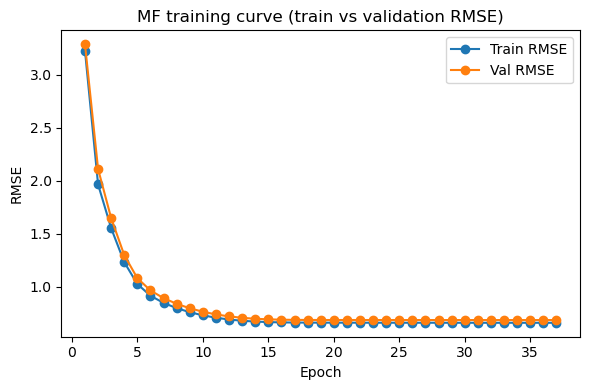

In [ ]:
# 7. Training loop with early stopping
# Trains the MF model with MSE loss, Adam, and early stopping based on validation RMSE, as in the training/evaluation plan.

plt.figure(figsize=(6, 4))
plt.plot(epoch_history, train_rmse_history, marker="o", label="Train RMSE")
plt.plot(epoch_history, val_rmse_history, marker="o", label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("MF training curve (train vs validation RMSE)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 7. Training loop with early stopping
# Trains the MF model with MSE loss, Adam, and early stopping based on validation RMSE, as in the training/evaluation plan.
# BPR fine-tuning: optimize pairwise ranking loss instead of MSE.
# Implements Bayesian Personalized Ranking objective as in PML's recommender section.
def bpr_finetune_optimized(model, train_dataset, n_items, n_epochs=3, batch_size=4096, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Main training loop over epochs for MF model (MSE objective).
    for epoch in range(1, n_epochs + 1):
        total_loss = 0.0
        n_samples = 0
        for users, items, ratings in loader:
            users = users.to(device)
            items = items.to(device)
            neg_items = torch.randint(0, n_items, (users.size(0),), device=device)
            pos_scores = model(users, items)
            neg_scores = model(users, neg_items)
            diff = pos_scores - neg_scores
            bpr_loss = -torch.log(torch.sigmoid(diff + 1e-8)).mean()
            optimizer.zero_grad()
            bpr_loss.backward()
            optimizer.step()
            total_loss += bpr_loss.item() * users.size(0)
            n_samples += users.size(0)
        print(f"BPR epoch {epoch:02d}, loss={total_loss / max(1, n_samples):.4f}")

# Build BPR dataset using only high ratings as positives
high_rating_mask = y_train >= 4
X_train_bpr = X_train[high_rating_mask].reset_index(drop=True)
y_train_bpr = y_train[high_rating_mask].reset_index(drop=True)

train_dataset_bpr = RatingDataset(X_train_bpr, y_train_bpr)
print("BPR positives:", len(train_dataset_bpr), "out of", len(y_train))

print("Starting BPR fine-tuning for ranking (high-rating positives only)...")
bpr_finetune_optimized(model, train_dataset_bpr, n_items=n_items, n_epochs=3, batch_size=4096, lr=1e-3)
print("Done BPR fine-tuning.")

BPR positives: 602055 out of 642912
Starting BPR fine-tuning for ranking (high-rating positives only)...
BPR epoch 01, loss=0.6722
BPR epoch 02, loss=0.6055
BPR epoch 03, loss=0.5045
Done BPR fine-tuning.


## 8. Example top-K recommendation for a user



In [12]:
# 8. Example top-K recommendation for a user  (presentation Section 4.5)
# Shows qualitative top-K recommendations for a chosen user to match the slide examples.

all_item_indices = torch.arange(n_items, device=device, dtype=torch.long)
item_ids_array = np.array(list(item2idx.keys()))

example_user_id = X_train["user_id"].iloc[0]
example_user_idx = user2idx[example_user_id]

with torch.no_grad():
    user_tensor = torch.tensor([example_user_idx], device=device, dtype=torch.long)
    users_tensor = user_tensor.repeat(n_items)
    scores = model(users_tensor, all_item_indices)
    topk_scores, topk_indices = torch.topk(scores, k=10)
    rec_item_idxs = topk_indices.cpu().tolist()

top10_items = [item_ids_array[i] for i in rec_item_idxs]
print("Example user:", example_user_id)
print("Top-10 recommended recipe_ids:", top10_items)

Example user: 498451
Top-10 recommended recipe_ids: [np.int64(39087), np.int64(2886), np.int64(67256), np.int64(32204), np.int64(69173), np.int64(82102), np.int64(10744), np.int64(28148), np.int64(27208), np.int64(54257)]


## 9. Simple Hit@K and NDCG@K evaluation on a subset


In [ ]:
# 9. Simple Hit@K and NDCG@K evaluation on a subset
# Computes ranking metrics (Hit@K, NDCG@K) on a subset of users, as in the evaluation section.

# Compute Hit@K and NDCG@K ranking metrics, as recommended for evaluating recommenders.
def hit_ndcg_at_k(model, df_train, df_test, user2idx, item2idx, k=10, max_users=1000, min_train_interactions=1):
    model.eval()
    users_test = df_test["user_id"].unique()
    rng = np.random.RandomState(42)
    rng.shuffle(users_test)
    users_test = users_test[:max_users]
    user_train_counts = df_train["user_id"].value_counts()
    hits = []
    ndcgs = []
    with torch.no_grad():
        for u in users_test:
            if u not in user2idx:
                continue
            if user_train_counts.get(u, 0) < min_train_interactions:
                continue
            user_idx = user2idx[u]
            user_train_items = set(df_train.loc[df_train["user_id"] == u, "recipe_id"].values.tolist())
            user_test_items = set(df_test.loc[df_test["user_id"] == u, "recipe_id"].values.tolist())
            if len(user_test_items) == 0:
                continue
            all_items = list(item2idx.keys())
            candidate_items = [i for i in all_items if i not in user_train_items]
            if len(candidate_items) <= k:
                continue
            item_indices = torch.tensor([item2idx[i] for i in candidate_items], device=device, dtype=torch.long)
            user_tensor = torch.tensor([user_idx], device=device, dtype=torch.long)
            users_tensor = user_tensor.repeat(len(candidate_items))
            scores = model(users_tensor, item_indices)
            topk_scores, topk_idx = torch.topk(scores, k=k)
            topk_item_indices = topk_idx.cpu().tolist()
            topk_items = [candidate_items[i] for i in topk_item_indices]
            hit = 1.0 if any(i in user_test_items for i in topk_items) else 0.0
            hits.append(hit)
            dcg = 0.0
            for rank, item_id in enumerate(topk_items, start=1):
                if item_id in user_test_items:
                    dcg += 1.0 / np.log2(rank + 1.0)
            idcg = 1.0
            ndcg = dcg / idcg
            ndcgs.append(ndcg)
    if len(hits) == 0:
        return np.nan, np.nan
    return float(np.mean(hits)), float(np.mean(ndcgs))

# Compute Hit@K and NDCG@K ranking metrics, as recommended for evaluating recommenders.
def hit_ndcg_at_k_sampled(model, df_train, df_test, user2idx, item2idx,
                          k=10, max_users=1000, n_neg=100, min_train_interactions=1):
    model.eval()
    users_test = df_test["user_id"].unique()
    rng = np.random.RandomState(42)
    rng.shuffle(users_test)
    users_test = users_test[:max_users]
    user_train_counts = df_train["user_id"].value_counts()
    all_items = list(item2idx.keys())
    hits = []
    ndcgs = []
    with torch.no_grad():
        for u in users_test:
            if u not in user2idx:
                continue
            if user_train_counts.get(u, 0) < min_train_interactions:
                continue
            user_idx = user2idx[u]
            user_train_items = set(df_train.loc[df_train["user_id"] == u, "recipe_id"].values.tolist())
            user_test_items = set(df_test.loc[df_test["user_id"] == u, "recipe_id"].values.tolist())
            if len(user_test_items) == 0:
                continue
            pos_item = rng.choice(list(user_test_items))
            neg_candidates = [i for i in all_items if i not in user_train_items and i not in user_test_items]
            if len(neg_candidates) < n_neg:
                continue
            neg_items = rng.choice(neg_candidates, size=n_neg, replace=False)
            candidate_items = [pos_item] + list(neg_items)
            item_indices = torch.tensor([item2idx[i] for i in candidate_items], device=device, dtype=torch.long)
            user_tensor = torch.tensor([user_idx], device=device, dtype=torch.long)
            users_tensor = user_tensor.repeat(len(candidate_items))
            scores = model(users_tensor, item_indices)
            topk_scores, topk_idx = torch.topk(scores, k=k)
            topk_indices = topk_idx.cpu().tolist()
            topk_items = [candidate_items[i] for i in topk_indices]
            hit = 1.0 if pos_item in topk_items else 0.0
            hits.append(hit)
            dcg = 0.0
            for rank, item_id in enumerate(topk_items, start=1):
                if item_id == pos_item:
                    dcg += 1.0 / np.log2(rank + 1.0)
            idcg = 1.0
            ndcgs.append(dcg / idcg)
    if len(hits) == 0:
        return np.nan, np.nan
    return float(np.mean(hits)), float(np.mean(ndcgs))

df_train_eval = X_train.assign(rating=y_train)
df_test_eval = X_test.assign(rating=y_test)

hit10_full, ndcg10_full = hit_ndcg_at_k(
    model,
    df_train_eval,
    df_test_eval,
    user2idx,
    item2idx,
    k=10,
    max_users=500,
    min_train_interactions=5,
)
print("Full-catalog Hit@10:", hit10_full)
print("Full-catalog NDCG@10:", ndcg10_full)

hit10_s, ndcg10_s = hit_ndcg_at_k_sampled(
    model,
    df_train_eval,
    df_test_eval,
    user2idx,
    item2idx,
    k=10,
    max_users=500,
    n_neg=100,
    min_train_interactions=5,
)
print("Sampled Hit@10:", hit10_s)
print("Sampled NDCG@10:", ndcg10_s)

Full-catalog Hit@10: 0.0673076923076923
Full-catalog NDCG@10: 0.03286187482446127
Sampled Hit@10: 0.625
Sampled NDCG@10: 0.43881722019935043


## 10. Exploratory data analysis (EDA) and descriptive statistics



Descriptive statistics for key numeric columns:
             rating       minutes       n_steps  n_ingredients   log_minutes  \
count  1.071520e+06  1.071520e+06  1.071520e+06   1.071520e+06  1.071520e+06   
mean   4.661499e+00  3.618359e+04  9.583096e+00   8.948438e+00  3.715459e+00   
std    7.230534e-01  8.801618e+06  5.755931e+00   3.681954e+00  1.087729e+00   
min    1.000000e+00  0.000000e+00  0.000000e+00   1.000000e+00  0.000000e+00   
25%    5.000000e+00  2.000000e+01  6.000000e+00   6.000000e+00  3.044522e+00   
50%    5.000000e+00  4.000000e+01  8.000000e+00   9.000000e+00  3.713572e+00   
75%    5.000000e+00  7.000000e+01  1.200000e+01   1.100000e+01  4.262680e+00   
max    5.000000e+00  2.147484e+09  1.450000e+02   4.300000e+01  2.148756e+01   

       steps_per_minute  ingredients_per_step  
count      1.071520e+06          1.071520e+06  
mean       4.004245e+01          1.228872e+00  
std        7.283315e+02          1.641680e+01  
min        0.000000e+00          2.7027

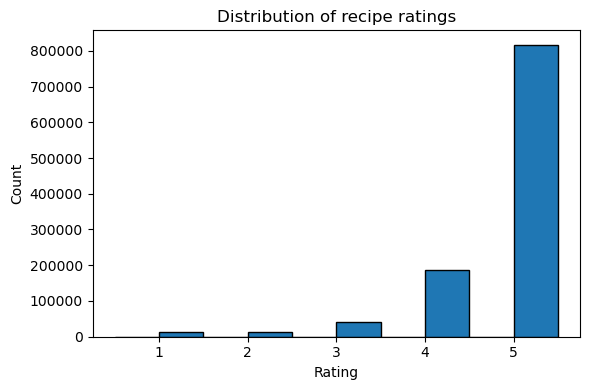

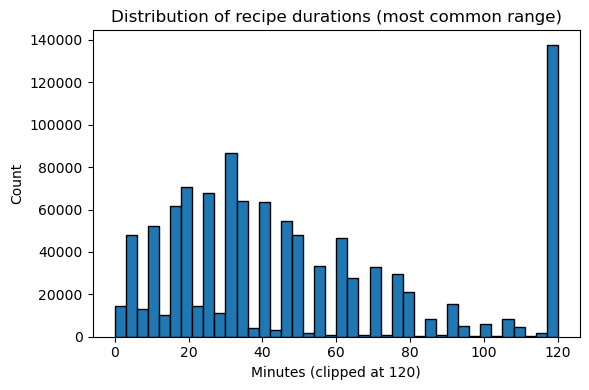

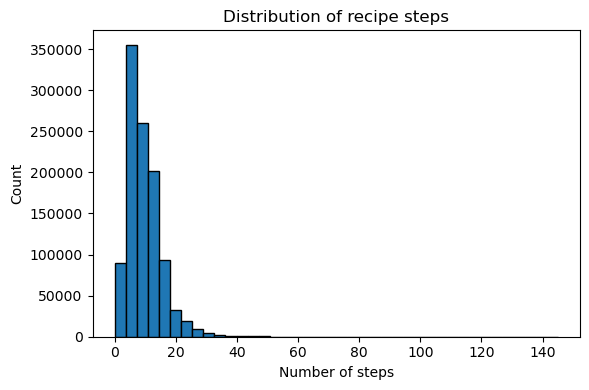

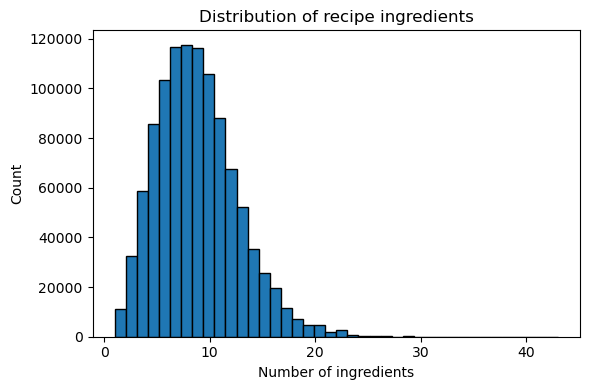

In [14]:
# 10. Exploratory data analysis (EDA) and descriptive statistics  (presentation Section 2.3)
# Produces the rating, user-activity, and item-popularity plots that appear in the EDA part of the talk.

# Descriptive statistics for key numeric columns
numeric_cols = [
    "rating",
    "minutes",
    "n_steps",
    "n_ingredients",
    "log_minutes",
    "steps_per_minute",
    "ingredients_per_step",
]

eda_stats = df[numeric_cols].describe()
print("Descriptive statistics for key numeric columns:")
print(eda_stats)

# Histogram of ratings
plt.figure(figsize=(6, 4))
plt.hist(df["rating"], bins=np.arange(0.5, 5.6, 0.5), edgecolor="black")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of recipe ratings")
plt.tight_layout()
plt.show()

# Histogram of recipe durations (clipped to show the bulk distribution)
minutes_clipped = df["minutes"].clip(upper=120)
plt.figure(figsize=(6, 4))
plt.hist(minutes_clipped, bins=40, edgecolor="black")
plt.xlabel("Minutes (clipped at 120)")
plt.ylabel("Count")
plt.title("Distribution of recipe durations (most common range)")
plt.tight_layout()
plt.show()

# Histogram of number of steps
plt.figure(figsize=(6, 4))
plt.hist(df["n_steps"], bins=40, edgecolor="black")
plt.xlabel("Number of steps")
plt.ylabel("Count")
plt.title("Distribution of recipe steps")
plt.tight_layout()
plt.show()

# Histogram of number of ingredients
plt.figure(figsize=(6, 4))
plt.hist(df["n_ingredients"], bins=40, edgecolor="black")
plt.xlabel("Number of ingredients")
plt.ylabel("Count")
plt.title("Distribution of recipe ingredients")
plt.tight_layout()
plt.show()

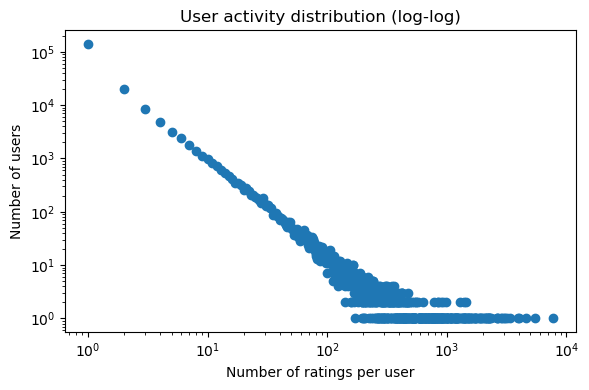

In [15]:
# 10. Exploratory data analysis (EDA) and descriptive statistics  (presentation Section 2.3)
# Produces the rating, user-activity, and item-popularity plots that appear in the EDA part of the talk.

user_activity = df["user_id"].value_counts()
activity_counts = user_activity.value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.loglog(activity_counts.index, activity_counts.values, marker="o", linestyle="none")
plt.xlabel("Number of ratings per user")
plt.ylabel("Number of users")
plt.title("User activity distribution (log-log)")
plt.tight_layout()
plt.show()

## 11. Model comparison and error analysis



          model  split      RMSE
0     User mean    val  0.712729
1     User mean   test  0.715103
2   Recipe mean    val  0.767214
3   Recipe mean   test  0.768503
4  MF (PyTorch)  train  0.693613
5  MF (PyTorch)    val  0.742457
6  MF (PyTorch)   test  0.741497


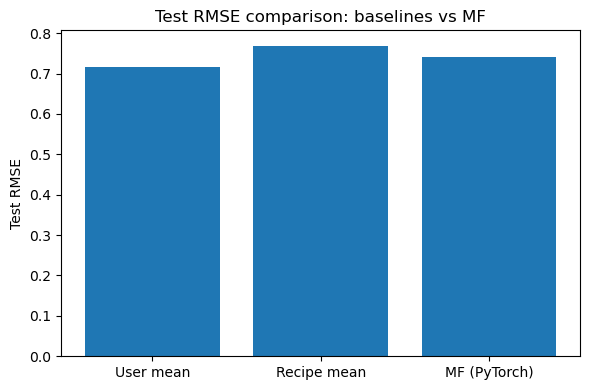

In [ ]:
# 11. Model comparison and error analysis
# Compares MF against baselines using RMSE and ranking metrics and inspects where the model does better or worse.

# Recompute RMSE for baselines and MF for a clean comparison table
# Baselines from earlier definitions
y_val_user = user_mean_predict(X_val)
y_test_user = user_mean_predict(X_test)
y_val_recipe = recipe_mean_predict(X_val)
y_test_recipe = recipe_mean_predict(X_test)

baseline_metrics = []
baseline_metrics.append({
    "model": "User mean",
    "split": "val",
    "RMSE": rmse_np(y_val, y_val_user),
})
baseline_metrics.append({
    "model": "User mean",
    "split": "test",
    "RMSE": rmse_np(y_test, y_test_user),
})
baseline_metrics.append({
    "model": "Recipe mean",
    "split": "val",
    "RMSE": rmse_np(y_val, y_val_recipe),
})
baseline_metrics.append({
    "model": "Recipe mean",
    "split": "test",
    "RMSE": rmse_np(y_test, y_test_recipe),
})

# MF RMSE using the trained (and BPR-finetuned) model
mf_train_rmse = rmse_loader(model, train_loader)
mf_val_rmse = rmse_loader(model, val_loader)
mf_test_rmse = rmse_loader(model, test_loader)

baseline_metrics.append({
    "model": "MF (PyTorch)",
    "split": "train",
    "RMSE": mf_train_rmse,
})
baseline_metrics.append({
    "model": "MF (PyTorch)",
    "split": "val",
    "RMSE": mf_val_rmse,
})
baseline_metrics.append({
    "model": "MF (PyTorch)",
    "split": "test",
    "RMSE": mf_test_rmse,
})

metrics_df = pd.DataFrame(baseline_metrics)
print(metrics_df)

# Plot test RMSE comparison
test_rows = metrics_df[metrics_df["split"] == "test"]
plt.figure(figsize=(6, 4))
plt.bar(test_rows["model"], test_rows["RMSE"])
plt.ylabel("Test RMSE")
plt.title("Test RMSE comparison: baselines vs MF")
plt.tight_layout()
plt.show()

## 12. Recommendation examples and ranking metrics



In [ ]:
# 12. Recommendation examples and ranking metrics
# Shows additional qualitative recommendation examples and ties them back to Hit@10 / NDCG@10.

# Show recommendation examples for a few random users
rng = np.random.RandomState(42)
unique_users_test = df_test_eval["user_id"].unique()
sample_users = rng.choice(unique_users_test, size=min(3, len(unique_users_test)), replace=False)

all_items_array = np.array(list(item2idx.keys()))

for u in sample_users:
    if u not in user2idx:
        continue
    user_idx = user2idx[u]

    # Items seen in train and test for this user
    user_train_items = set(df_train_eval.loc[df_train_eval["user_id"] == u, "recipe_id"].values.tolist())
    user_test_items = set(df_test_eval.loc[df_test_eval["user_id"] == u, "recipe_id"].values.tolist())

    # Score all items for this user
    with torch.no_grad():
        user_tensor = torch.tensor([user_idx], device=device, dtype=torch.long)
        users_tensor = user_tensor.repeat(n_items)
        all_item_indices = torch.arange(n_items, device=device, dtype=torch.long)
        scores = model(users_tensor, all_item_indices)
        topk_scores, topk_indices = torch.topk(scores, k=10)
        rec_item_idxs = topk_indices.cpu().tolist()

    recommended_items = [all_items_array[i] for i in rec_item_idxs]

    print(f"User id: {u}")
    print("  Train items (sample):", list(user_train_items)[:10])
    print("  Test items:", list(user_test_items))
    print("  Top-10 recommended items:", recommended_items)
    print("-" * 60)

# Also print the global Hit@10 and NDCG@10 values computed earlier
print("Full-catalog Hit@10:", hit10_full)
print("Full-catalog NDCG@10:", ndcg10_full)
print("Sampled Hit@10:", hit10_s)
print("Sampled NDCG@10:", ndcg10_s)

User id: 1037680
  Train items (sample): [50719]
  Test items: [132263]
  Top-10 recommended items: [np.int64(39087), np.int64(2886), np.int64(69173), np.int64(67256), np.int64(10744), np.int64(32204), np.int64(107786), np.int64(28148), np.int64(82102), np.int64(33671)]
------------------------------------------------------------
User id: 1800893886
  Train items (sample): []
  Test items: [384069]
  Top-10 recommended items: [np.int64(107786), np.int64(486496), np.int64(38298), np.int64(486261), np.int64(2886), np.int64(9272), np.int64(69173), np.int64(10744), np.int64(39087), np.int64(69630)]
------------------------------------------------------------
User id: 844963
  Train items (sample): []
  Test items: [395683]
  Top-10 recommended items: [np.int64(107786), np.int64(486496), np.int64(38298), np.int64(486261), np.int64(2886), np.int64(9272), np.int64(69173), np.int64(10744), np.int64(39087), np.int64(69630)]
------------------------------------------------------------
Full-catal

## 13. Recommendation quality vs user activity (long-tail analysis)


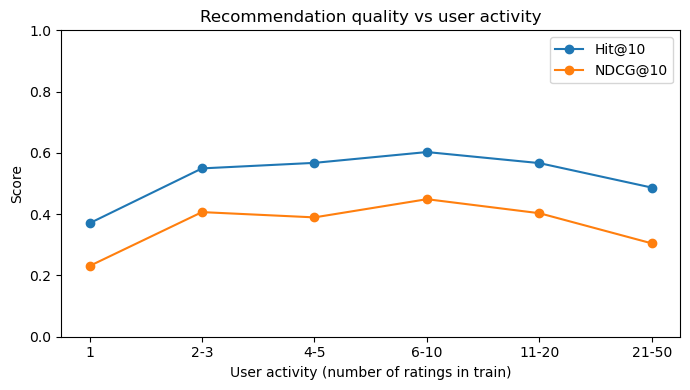

In [ ]:
# 13. Recommendation quality vs user activity (long-tail analysis)
# Analyzes how Hit@10 / NDCG@10 vary with user history length, illustrating the long-tail behavior discussed in the slides.

# Analyze Hit@10 / NDCG@10 as a function of user activity

# Analyze ranking quality across user-activity buckets (long-tail analysis).
def hit_ndcg_by_user_activity(model, df_train, df_test, user2idx, item2idx,
                              k=10, max_users_per_bin=300, n_neg=100):
    # Define activity bins
    bins = [1, 3, 6, 11, 21, 51, np.inf]
    labels = ["1", "2-3", "4-5", "6-10", "11-20", "21-50", "50+"]

    # Count how many ratings each user has in the training set
    user_counts = df_train["user_id"].value_counts()

    # Assign users to bins
    users_by_bin = {lab: [] for lab in labels}
    for u, c in user_counts.items():
        for b in range(len(bins) - 1):
            if bins[b] <= c < bins[b + 1]:
                users_by_bin[labels[b]].append(u)
                break

    bin_labels = []
    hit_by_bin = []
    ndcg_by_bin = []

    for lab in labels:
        users_in_bin = users_by_bin[lab]
        if not users_in_bin:
            continue
        rng = np.random.RandomState(42)
        users_array = np.array(users_in_bin)
        rng.shuffle(users_array)
        users_subset = users_array[:max_users_per_bin]

        df_train_sub = df_train[df_train["user_id"].isin(users_subset)]
        df_test_sub = df_test[df_test["user_id"].isin(users_subset)]

        hit, ndcg = hit_ndcg_at_k_sampled(
            model,
            df_train_sub,
            df_test_sub,
            user2idx,
            item2idx,
            k=k,
            max_users=len(users_subset),
            n_neg=n_neg,
            min_train_interactions=1,
        )
        bin_labels.append(lab)
        hit_by_bin.append(hit)
        ndcg_by_bin.append(ndcg)

    return bin_labels, np.array(hit_by_bin), np.array(ndcg_by_bin)

# Construct train and test DataFrames with ratings for this analysis
df_train_full = df_train_eval.copy()
df_test_full = df_test_eval.copy()

bin_labels, hit_by_bin, ndcg_by_bin = hit_ndcg_by_user_activity(
    model, df_train_full, df_test_full, user2idx, item2idx, k=10, max_users_per_bin=300
)

plt.figure(figsize=(7, 4))
plt.plot(bin_labels, hit_by_bin, marker="o", label="Hit@10")
plt.plot(bin_labels, ndcg_by_bin, marker="o", label="NDCG@10")
plt.xlabel("User activity (number of ratings in train)")
plt.ylabel("Score")
plt.title("Recommendation quality vs user activity")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()